In [5]:
%pip install scikit-surprise

  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163491 sha256=1335ba8b658ac5f95affaea98ec760a956ba86416c0121086718a35945a3acb4
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [73]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
import seaborn as sns
import math
%matplotlib inline

<Figure size 500x500 with 0 Axes>

In [74]:
# drive.mount("/content/drive")
# !gzip -d /content/drive/MyDrive/train.gz
# data = pd.read_csv("/content/drive/MyDrive/train")

In [75]:
chunksize = 10 ** 7
num_of_chunk = 0
train = pd.DataFrame()

for chunk in pd.read_csv('/content/drive/MyDrive/train.gz',chunksize=chunksize):
    num_of_chunk = num_of_chunk + 1
    train = pd.concat([train,chunk.sample(frac=0.01)],axis = 0,ignore_index = True)
    print(f'NUMBER {str(num_of_chunk)} is done.')

NUMBER 1 is done.
NUMBER 2 is done.
NUMBER 3 is done.
NUMBER 4 is done.
NUMBER 5 is done.


In [76]:
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.085842e+19,0,14102300,1005,0,85f751fd,c4e18dd6,50e219e0,1779deee,2347f47a,...,1,0,21724,320,50,2502,0,35,100084,221
1,1.906853e+17,0,14102206,1005,0,85f751fd,c4e18dd6,50e219e0,48ef6336,2347f47a,...,1,0,21790,320,50,2513,3,35,-1,68
2,1.322256e+19,0,14102223,1005,0,85f751fd,c4e18dd6,50e219e0,a5b6896d,d18c63a1,...,1,3,20016,300,250,2285,2,39,-1,23
3,1.741020e+19,0,14102111,1002,0,9e8e8d09,16a36ef3,50e219e0,ecad2386,7801e8d9,...,0,0,17081,320,50,1921,3,47,100079,23
4,1.267558e+19,1,14102111,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,1,0,17614,320,50,1993,2,1063,100083,33


In [77]:
train.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

In [78]:
train.dtypes

id                  float64
click                 int64
hour                  int64
C1                    int64
banner_pos            int64
site_id              object
site_domain          object
site_category        object
app_id               object
app_domain           object
app_category         object
device_id            object
device_ip            object
device_model         object
device_type           int64
device_conn_type      int64
C14                   int64
C15                   int64
C16                   int64
C17                   int64
C18                   int64
C19                   int64
C20                   int64
C21                   int64
dtype: object

In [79]:
corr_matrix = train.corr()

corr_matrix.style.background_gradient(cmap='coolwarm')

<ipython-input-79-4f23646ead6e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
id,1.000000,0.001698,-0.001351,0.000559,0.000910,0.000573,0.001040,-0.001127,-0.002562,-0.000974,-0.001232,0.001729,0.000635,-0.000706,-0.004424
click,0.001698,1.000000,-0.009031,-0.036939,0.024850,-0.039071,-0.082162,-0.059492,-0.032722,0.129387,-0.055423,0.021247,-0.006435,-0.057161,-0.070721
hour,-0.001351,-0.009031,1.000000,-0.006179,0.028017,-0.006014,0.050099,0.196465,0.022363,0.002806,0.186739,0.012166,0.044446,0.025468,0.067352
C1,0.000559,-0.036939,-0.006179,1.000000,0.290613,0.894762,0.199584,0.053604,0.125960,0.064927,0.061548,-0.042175,0.003787,-0.035017,0.036088
banner_pos,0.000910,0.024850,0.028017,0.290613,1.000000,0.326933,-0.080481,-0.012048,0.066948,0.030647,-0.031653,0.097114,0.132065,0.054870,-0.096985
device_type,0.000573,-0.039071,-0.006014,0.894762,0.326933,1.000000,0.213907,0.042189,0.188901,0.068515,0.047810,-0.046684,-0.001351,-0.048175,0.037137
device_conn_type,0.001040,-0.082162,0.050099,0.199584,-0.080481,0.213907,1.000000,0.069778,0.071037,-0.013359,0.081959,-0.063479,-0.010790,0.090534,0.063754
C14,-0.001127,-0.059492,0.196465,0.053604,-0.012048,0.042189,0.069778,1.000000,0.004184,0.037929,0.977365,-0.230823,-0.134588,0.026659,0.409136
C15,-0.002562,-0.032722,0.022363,0.125960,0.066948,0.188901,0.071037,0.004184,1.000000,-0.060189,0.003115,0.012536,0.051511,0.008266,0.002803
C16,-0.000974,0.129387,0.002806,0.064927,0.030647,0.068515,-0.013359,0.037929,-0.060189,1.000000,0.048155,0.084134,-0.070062,-0.044342,-0.083147


In [80]:
train.click.value_counts()

0    336175
1     68115
Name: click, dtype: int64

<Axes: >

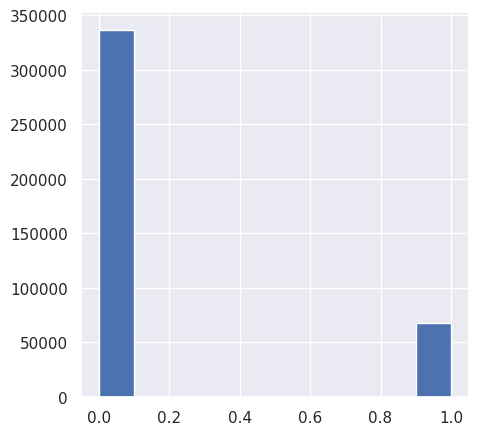

In [81]:
train.click.hist(figsize=(5, 5))

In [82]:
train.device_type.value_counts()

1    372955
0     22167
4      7843
5      1325
Name: device_type, dtype: int64

In [83]:
train.device_conn_type.value_counts()

0    348206
2     33443
3     22189
5       452
Name: device_conn_type, dtype: int64

In [84]:
train.device_model.value_counts()

8a4875bd    24612
1f0bc64f    14370
d787e91b    13988
76dc4769     7527
be6db1d7     7444
            ...  
4d30bb52        1
a108a253        1
804e4d03        1
36885bc8        1
ecadc865        1
Name: device_model, Length: 4376, dtype: int64

In [85]:
X = train.copy()

In [86]:
X = X.drop(['id', 'site_id', 'site_domain', 'app_id', 'app_domain', 'device_ip', 'device_id'], axis=1)

In [87]:
X.head()

,click,hour,C1,banner_pos,site_category,app_category,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,14102300,1005,0,50e219e0,f95efa07,78d9bd10,1,0,21724,320,50,2502,0,35,100084,221
1,0,14102206,1005,0,50e219e0,f95efa07,c4cff2ea,1,0,21790,320,50,2513,3,35,-1,68
2,0,14102223,1005,0,50e219e0,0f2161f8,213de82a,1,3,20016,300,250,2285,2,39,-1,23
3,0,14102111,1002,0,50e219e0,07d7df22,911a3c09,0,0,17081,320,50,1921,3,47,100079,23
4,1,14102111,1005,1,f028772b,07d7df22,711ee120,1,0,17614,320,50,1993,2,1063,100083,33


In [88]:
X = X.drop('C14', axis=1)

In [89]:
X.head()

,click,hour,C1,banner_pos,site_category,app_category,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C20,C21
0,0,14102300,1005,0,50e219e0,f95efa07,78d9bd10,1,0,320,50,2502,0,35,100084,221
1,0,14102206,1005,0,50e219e0,f95efa07,c4cff2ea,1,0,320,50,2513,3,35,-1,68
2,0,14102223,1005,0,50e219e0,0f2161f8,213de82a,1,3,300,250,2285,2,39,-1,23
3,0,14102111,1002,0,50e219e0,07d7df22,911a3c09,0,0,320,50,1921,3,47,100079,23
4,1,14102111,1005,1,f028772b,07d7df22,711ee120,1,0,320,50,1993,2,1063,100083,33


In [91]:
X['site_category'] = X['site_category'].astype('category')
X['site_category'] = X['site_category'].cat.codes

X['app_category'] = X['app_category'].astype('category')
X['app_category'] = X['app_category'].cat.codes

X['device_model'] = X['device_model'].astype('category')
X['device_model'] = X['device_model'].cat.codes

In [93]:
X.head()

,click,hour,C1,banner_pos,site_category,app_category,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C20,C21
0,0,14102300,1005,0,5,23,2075,1,0,320,50,2502,0,35,100084,221
1,0,14102206,1005,0,5,23,3374,1,0,320,50,2513,3,35,-1,68
2,0,14102223,1005,0,5,3,560,1,3,300,250,2285,2,39,-1,23
3,0,14102111,1002,0,5,0,2486,0,0,320,50,1921,3,47,100079,23
4,1,14102111,1005,1,18,0,1931,1,0,320,50,1993,2,1063,100083,33


In [95]:
X['hour'] = pd.to_datetime(X['hour'], format = '%y%m%d%H')

In [104]:
X['day'] = X['hour'].dt.day

In [106]:
X['hour'] = X['hour'].dt.hour

In [107]:
X.head()

,click,hour,C1,banner_pos,site_category,app_category,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C20,C21,day
0,0,0,1005,0,5,23,2075,1,0,320,50,2502,0,35,100084,221,23
1,0,6,1005,0,5,23,3374,1,0,320,50,2513,3,35,-1,68,22
2,0,23,1005,0,5,3,560,1,3,300,250,2285,2,39,-1,23,22
3,0,11,1002,0,5,0,2486,0,0,320,50,1921,3,47,100079,23,21
4,1,11,1005,1,18,0,1931,1,0,320,50,1993,2,1063,100083,33,21


In [115]:
X.describe()

,click,hour,C1,banner_pos,site_category,app_category,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C20,C21,day
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,0.168481,11.294017,1004.970163,0.287630,8.312397,2.900801,2191.187279,1.016478,0.335682,318.944649,60.145747,2112.170778,1.429471,227.054132,53280.074464,83.350310,25.467991
std,0.374293,5.956111,1.098384,0.507689,6.833530,6.051147,1238.376559,0.530652,0.860294,21.933883,47.516591,609.771493,1.326677,350.448053,49952.833826,70.201366,2.964856
min,0.000000,0.000000,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000,21.000000
25%,0.000000,7.000000,1005.000000,0.000000,3.000000,0.000000,1062.000000,1.000000,0.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,23.000000,23.000000
50%,0.000000,11.000000,1005.000000,0.000000,5.000000,0.000000,2296.000000,1.000000,0.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,100049.000000,61.000000,26.000000
75%,0.000000,16.000000,1005.000000,1.000000,18.000000,3.000000,3248.000000,1.000000,0.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,100094.000000,101.000000,28.000000
max,1.000000,23.000000,1012.000000,7.000000,19.000000,24.000000,4375.000000,5.000000,5.000000,1024.000000,1024.000000,2758.000000,3.000000,1839.000000,100248.000000,255.000000,30.000000


In [110]:
X.shape

(404290, 17)

In [118]:
import math
from sklearn import preprocessing
from sklearn.decomposition import PCA


# Функция для стандартизации фич
def scale_features(df):
    scaled = preprocessing.StandardScaler().fit_transform(df)
    scaled = pd.DataFrame(scaled, columns=df.columns)
    return scaled


In [139]:
X_scaled = preprocessing.scale(X.drop('click', axis=1))

In [140]:
X_scaled.shape

(404290, 16)

In [141]:
pca = PCA(n_components=16)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_)

[0.13919523 0.13096336 0.09964779 0.07790121 0.0698224  0.06349734
 0.06168603 0.06102753 0.05689591 0.05482952 0.04716669 0.04443293
 0.03770863 0.02495101 0.02418637 0.00608804]


In [142]:
pca.singular_values_

array([948.89611357, 920.41015917, 802.86093166, 709.86964335,
       672.05355286, 640.89110479, 631.6840372 , 628.30335378,
       606.6623201 , 595.54378621, 552.36251292, 536.11626945,
       493.88620434, 401.74508545, 395.54130773, 198.4472487 ])

In [143]:
X_new = pca.transform(X_scaled)

In [144]:
X_new.shape

(404290, 16)

In [146]:
pd.DataFrame(pca.components_, columns=X.columns[1:])

,hour,C1,banner_pos,site_category,app_category,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C20,C21,day
0,0.015312,0.610875,0.353678,0.120250,0.045577,0.101757,0.620502,0.198862,0.189261,0.046759,0.080018,-0.032292,0.040757,0.000966,0.043759,0.031934
1,0.041370,-0.047314,0.340078,0.380130,-0.209198,0.066905,-0.050764,-0.222965,-0.006950,0.019283,-0.369628,0.434582,0.222247,0.084142,-0.496669,-0.079421
2,0.113637,0.099391,-0.346919,-0.435710,0.448126,0.024854,0.110958,0.284246,0.075088,0.094339,-0.326566,0.331136,0.029157,-0.096879,-0.346121,-0.107703
3,0.121429,-0.121097,0.008682,0.142852,0.262455,-0.047378,-0.121223,0.309751,0.227056,-0.451273,0.078386,0.024403,0.425381,0.446782,0.045436,0.351811
4,0.326051,-0.028619,0.042415,-0.000928,-0.013204,-0.011021,-0.042485,0.076880,-0.224169,0.539770,0.317209,0.235300,-0.114292,0.086679,-0.105537,0.594773
5,-0.243967,-0.029725,0.046103,0.009409,0.082098,-0.592037,0.002543,-0.188738,0.428605,0.023887,0.072923,0.130598,0.132299,-0.487760,-0.022853,0.286224
6,0.473752,0.027832,0.020619,-0.040512,-0.220230,-0.672255,0.042885,0.123754,0.061944,0.127834,-0.131913,-0.197545,-0.055773,0.295551,-0.036182,-0.294553
7,-0.731870,-0.004673,-0.013233,-0.038892,-0.041762,-0.190712,-0.013418,0.231050,-0.050601,0.345686,0.096391,0.095161,0.052645,0.456769,-0.063530,-0.122988
8,0.059532,-0.114249,-0.100003,-0.123688,-0.271319,0.314535,-0.050574,-0.074978,0.791440,0.146282,0.033463,0.023298,-0.277657,0.218625,-0.051935,0.018734
9,0.060273,0.020323,-0.076957,-0.292535,-0.183570,0.163616,0.035581,-0.198156,0.027455,0.349546,-0.104257,-0.276698,0.763588,-0.027636,0.092771,0.025496


In [149]:
Y = X['click']
Y

0         0
1         0
2         0
3         0
4         1
         ..
404285    1
404286    0
404287    0
404288    0
404289    0
Name: click, Length: 404290, dtype: int64

In [150]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X_new, Y, test_size=0.1, random_state=42)

In [147]:
model = SVD(n_factors=5, n_epochs=100, lr_all=0.005, reg_all=0.1, biased=True, random_state=42)

In [151]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    n_iter_no_change=35,
    shuffle=True,
    max_iter=5500,
    warm_start=True
)

In [152]:
sgd.partial_fit(X_train, Y_train, classes=np.unique(Y_train))

SGDClassifier(loss='log_loss', max_iter=5500, n_iter_no_change=35,
              warm_start=True)

In [156]:
from sklearn.metrics import log_loss


preds_val = sgd.predict_proba(X_valid)
preds_val = np.array(list(map(lambda x: x[1], preds_val)))
# print(preds_val)
log_loss(y_pred=preds_val, y_true=Y_valid)

0.4635074454942228

In [157]:
preds_val.shape

(40429,)

In [112]:
cross_validate(algo, X, measures=['RMSE', 'MAE'], cv=5, verbose=True)

AttributeError: ignored